## Notebook to compare thresholds on trainval


In [5]:
#imports
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('/home/co-ripa1/rds/hpc-work/scripts/meld_classifier')
from meld_classifier.meld_cohort import MeldSubject,MeldCohort
from meld_graph.training import tp_fp_fn_tn, dice_coeff
from meld_graph.icospheres import IcoSpheres
from meld_graph.graph_tools import GraphTools
import itertools
import pandas as pd
from meld_graph.evaluation import load_prediction
from meld_graph import experiment

Text(0.5, 1.0, ' threshold function for different slopes')

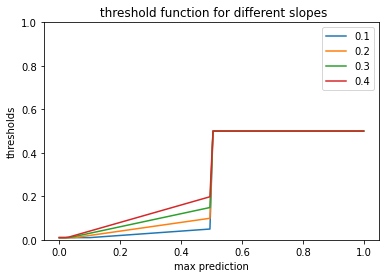

In [44]:
# plot thresholds
max_predictions = np.linspace(0,1,100)

for slope in [0.1,0.2,0.3,0.4]:
    thresholds = [0.5 if x>=0.5 else np.max([x*slope,0.01]) for x in max_predictions]
    plt.plot(max_predictions, thresholds, label=slope)
plt.xlabel('max prediction')
plt.ylabel('thresholds')
plt.ylim([0,1])
plt.legend()
plt.title(' threshold function for different slopes')

In [7]:
def df_stats(df):
    sensitivity = np.mean(df['detected'][df['group']])
    specificity = (df['number FP clusters'][df['group']==0]==0).mean()
    total_detected = np.sum(df['number TP clusters'][df['group']])
    total_predicted = np.sum(df['number FP clusters'][df['group']])
    ppv = total_detected / (total_predicted + total_detected)
    iou = np.mean(df[(df['group'])&(df['detected'])]['IOU'])
    iou_plus = np.mean(df[(df['group'])&(df['detected'])]['IOU_plus'])
    return np.round(sensitivity,2),np.round(specificity,2),np.round(ppv,2), np.round(iou,2), np.round(iou_plus,2)

# bootstrapped confidence intervals
def bootstrap_CI(df, n=10000, func=df_stats):
    """Calculate confidence intervals for a given function"""
    bootstrapped = []
    for i in range(n):
        bootstrapped.append(func(df.sample(len(df), replace=True)))
    return np.percentile(np.array(bootstrapped), [2.5, 97.5],axis=0)

### load results for meld graph model

In [39]:
model = '23-10-30_LVHZ_dcp'

threshold_slope = 0.2

experiment_dir = '/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350'
pred_file = os.path.join(experiment_dir,model,'s_0','fold_all_train_thresholds', f'thresh_slope_{threshold_slope}','results_best_model', 'predictions_trainval.hdf5')
cohort= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5',
                        dataset='MELD_dataset_v6.csv')

with h5py.File(pred_file, "r") as f:
    subjects = list(f.keys())

len(subjects)

458

In [40]:
df=pd.DataFrame()
subjects_dictionary={}
values={}
for si,subj in enumerate(subjects):
    if si%100==0:
        print(si)
    values['ID']=subj
    s = MeldSubject(subj,cohort=cohort)
    values['group']= True if s.group=='patient' else False
    labels_hemis = {}
    dists={}
    labels = np.zeros(len(cohort.cortex_label)*2)
    for hemi in ['lh','rh']:
        dists[hemi], labels_hemis[hemi] = s.load_feature_lesion_data(
                    features=['.on_lh.boundary_zone.mgh'], hemi=hemi, features_to_ignore=[]
                )
        if np.sum(dists[hemi])==0:
            dists[hemi] +=200
    labels = np.hstack([labels_hemis['lh'][cohort.cortex_mask],labels_hemis['rh'][cohort.cortex_mask]])
    borderzones = np.vstack([dists['lh'][cohort.cortex_mask,:],dists['rh'][cohort.cortex_mask,:]]).ravel()<20
    
    #load pred from graph classifier
    result_hemis = load_prediction(subj,pred_file, dset='prediction_clustered')
    result = np.hstack([result_hemis['lh'],result_hemis['rh']])
    values['model']='graph'
    
    result_raw_hemis = load_prediction(subj,pred_file, dset='prediction')
    values['max_pred'] = max(np.hstack([result_raw_hemis['lh'],result_raw_hemis['rh']]))
    values['size_cluster'] = (result>0).sum()
    #add detection with borderzone
    if labels.sum()>0:
        values['detected'] = np.logical_and(result, borderzones).any()
        clusters_in_borderzone = set(result[borderzones.astype('bool')])
        #remove the 0 cluster
        if 0 in clusters_in_borderzone:
            clusters_in_borderzone.remove(0)
        values['number TP clusters'] = len(clusters_in_borderzone)
        values['size_pred'] = len(result[borderzones.astype('bool')])
        values['IOU'] = (np.logical_and(result, labels)).sum() / (np.logical_or(result, labels)).sum() 
        values['IOU_plus'] = (np.logical_and(result, borderzones)).sum() / (np.logical_or(result, borderzones)).sum() 
    
    else:
        values['number TP clusters'] = 0
        values['IOU'] = np.nan
        values['IOU_plus'] = np.nan
    
    # add number of FP clusters : total clusters - TP clusters
    values['number FP clusters']=len(set(result_hemis['lh']))+len(set(result_hemis['rh']))-2-values['number TP clusters']
    df=pd.concat([df,pd.DataFrame([values])])
    
    
df = df.reset_index()
df.head()

0
100
200
300
400


,index,ID,group,model,max_pred,size_cluster,detected,number TP clusters,size_pred,IOU,IOU_plus,number FP clusters
0,0,MELD2_H7_3T_FCD_003,True,graph,0.959784,6499,True,1,10613,0.435346,0.580347,0
1,0,MELD2_H7_3T_FCD_006,True,graph,0.410296,7629,False,0,12586,0.000000,0.000000,2
2,0,MELD2_H7_3T_FCD_007,True,graph,0.755917,2622,True,1,17950,0.432562,0.146072,0
3,0,MELD2_H7_3T_FCD_008,True,graph,0.532610,38044,True,1,68821,0.349417,0.387533,0
4,0,MELD2_H7_3T_FCD_010,True,graph,0.972140,5192,True,1,15958,0.417202,0.296035,1


In [35]:
print('all together')
dfsub = df.copy()
print(len(dfsub))
sensitivity, specificity, ppv, iou, iou_plus = df_stats(dfsub)
print('sensitivity specificity ppv iou iou+')
print(sensitivity,specificity,ppv, iou, iou_plus)
# print(bootstrap_CI(dfsub))

all together
458
sensitivity specificity ppv iou iou+
0.85 0.79 0.77 0.32 0.24


In [ ]:
_, _, ppv_graph = df_stats(df)
ppv_graph_CI = bootstrap_CI(df)[:,2]
print(ppv_graph,ppv_graph_CI)

In [20]:
df[(df['group'])&(df['max_pred']<0.3)&(df['detected'])]

,index,ID,group,model,max_pred,size_cluster,detected,number TP clusters,size_pred,IOU,IOU_plus,number FP clusters
25,0,MELD_H10_3T_FCD_0006,True,graph,0.014739,303,True,2,8233,0.000000,0.036551,0
32,0,MELD_H11_3T_FCD_0013,True,graph,0.183184,2851,True,1,25533,0.417646,0.111659,0
39,0,MELD_H11_3T_FCD_0026,True,graph,0.231420,1568,True,1,10156,0.388132,0.154391,0
65,0,MELD_H12_3T_FCD_0001,True,graph,0.168704,3476,True,1,9222,0.307384,0.348699,0
130,0,MELD_H15_3T_FCD_0005,True,graph,0.223490,6779,True,1,9928,0.175656,0.403950,0
135,0,MELD_H16_3T_FCD_009,True,graph,0.258017,4717,True,1,13479,0.406740,0.349952,0
149,0,MELD_H17_15T_FCD_0009,True,graph,0.157850,3007,True,1,4266,0.023612,0.352110,0
158,0,MELD_H17_3T_FCD_0025,True,graph,0.272431,7427,True,1,5975,0.020232,0.247278,0
173,0,MELD_H17_3T_FCD_0060,True,graph,0.243162,1198,True,1,8916,0.031584,0.118805,0
184,0,MELD_H17_3T_FCD_0088,True,graph,0.067029,612,True,2,6612,0.000000,0.085826,0


Text(0, 0.5, 'number clusters')

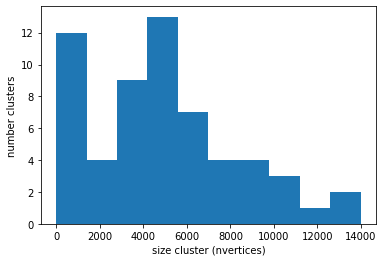

In [12]:
plt.hist(df[(df['group'])&(df['max_pred']<0.3)]['size_cluster'].values)
plt.xlabel('size cluster (nvertices)')
plt.ylabel('number clusters')

Text(0.5, 0, 'max prediction')

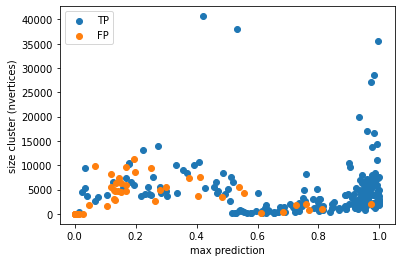

In [41]:
plt.scatter(df[(df['group'])&(df['detected'])]['max_pred'].values, df[(df['group'])&(df['detected'])]['size_cluster'].values, label='TP')
plt.scatter(df[(df['group'])&~(df['detected'])]['max_pred'].values, df[(df['group'])&~(df['detected'])]['size_cluster'].values, label='FP')
# plt.scatter(df[(df['group'])]['max_pred'].values, df[(df['group'])]['size_cluster'].values)
plt.legend()
plt.ylabel('size cluster (nvertices)')
plt.xlabel('max prediction')

Text(0.5, 0, 'max prediction')

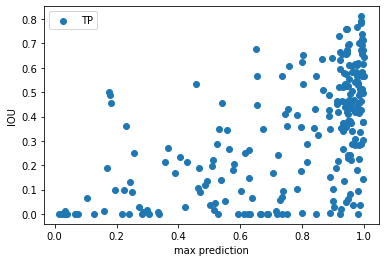

In [13]:
plt.scatter(df[(df['group'])&(df['detected'])]['max_pred'].values, df[(df['group'])&(df['detected'])]['IOU'].values, label='TP')
plt.legend()
plt.ylabel('IOU')
plt.xlabel('max prediction')

(array([ 4.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  3.,  1.,  3.,  2.,  2.,
         3.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,  0.,  2.,  3.,  2.,  5.,
         4.,  3.,  2.,  2.,  3.,  4.,  3.,  3.,  2.,  4.,  5.,  5.,  0.,
         7.,  3.,  1.,  4.,  2.,  8.,  9., 17., 31., 20., 42.]),
 array([0.01473932, 0.03443903, 0.05413875, 0.07383846, 0.09353817,
        0.11323789, 0.1329376 , 0.15263732, 0.17233703, 0.19203673,
        0.21173646, 0.23143616, 0.2511359 , 0.27083558, 0.2905353 ,
        0.31023502, 0.32993475, 0.34963444, 0.36933416, 0.38903388,
        0.40873358, 0.4284333 , 0.44813302, 0.4678327 , 0.48753244,
        0.5072321 , 0.5269319 , 0.5466316 , 0.56633127, 0.586031  ,
        0.6057307 , 0.6254304 , 0.64513016, 0.66482985, 0.68452954,
        0.7042293 , 0.723929  , 0.74362874, 0.76332843, 0.7830281 ,
        0.8027279 , 0.8224276 , 0.84212726, 0.861827  , 0.8815267 ,
        0.9012264 , 0.92092615, 0.94062585, 0.96032554, 0.9800253 ,
        0.999725  ], dtype=float32),

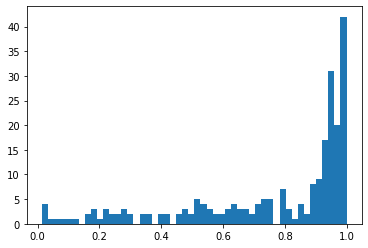

In [14]:
plt.hist(df[(df['group'])&(df['detected'])]['max_pred'].values,bins=50)

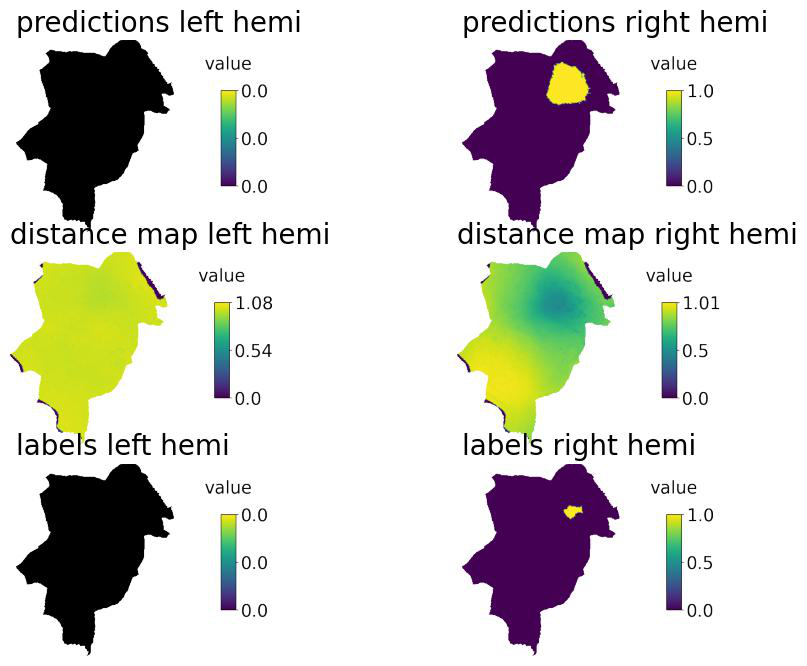

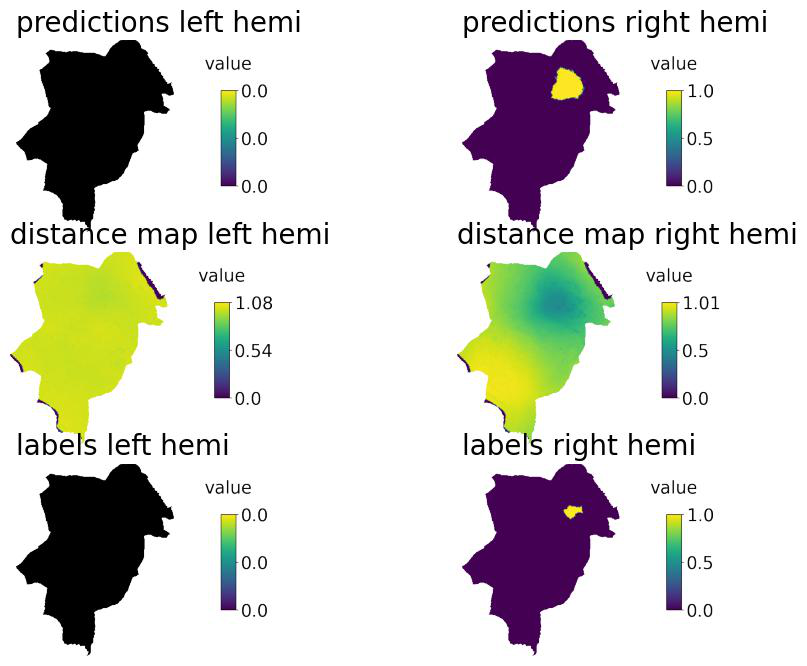

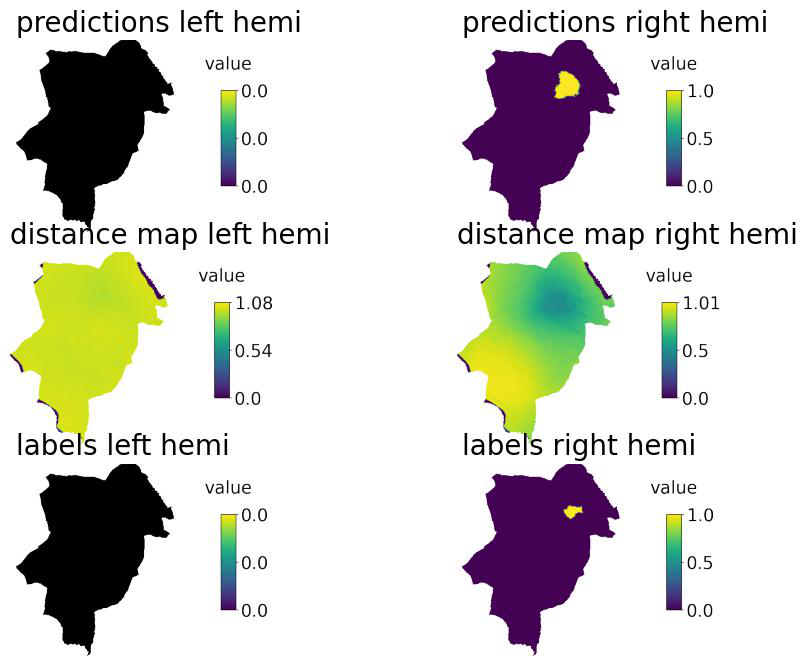

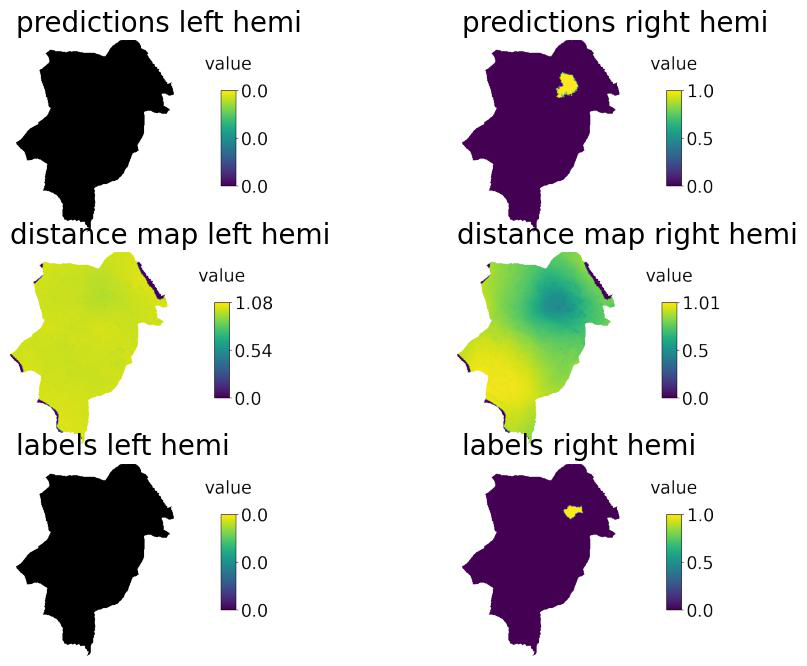

In [43]:
from IPython.display import display
from PIL import Image

# subject = 'MELD_H21_3T_FCD_0029'
subject = "MELD_H12_3T_FCD_0001"
path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_train_thresholds/thresh_slope_0.1/results_best_model/images"
image = os.path.join(path, subject+'_trainval.jpg' )
display(Image.open(image))

path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_train_thresholds/thresh_slope_0.2/results_best_model/images"
image = os.path.join(path, subject+'_trainval.jpg' )
display(Image.open(image))

path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_train_thresholds/thresh_slope_0.3/results_best_model/images"
image = os.path.join(path, subject+'_trainval.jpg' )
display(Image.open(image))

path="/rds/project/kw350/rds-kw350-meld/experiments_graph/kw350/23-10-30_LVHZ_dcp/s_0/fold_all_train_thresholds/thresh_slope_0.4/results_best_model/images"
image = os.path.join(path, subject+'_trainval.jpg' )
display(Image.open(image))
